In [1]:
import pickle
from CNN import *
from keras.datasets import mnist
from keras.utils import to_categorical

def save_weights(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


def load_weights(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model


def preprocess_data(x, y, limit):
    x = x.reshape(x.shape[0], 1, 28, 28)
    x = x.astype("float32") / 255
    y = to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = preprocess_data(x_train, y_train, y_train.shape[0])
x_test, y_test = preprocess_data(x_test, y_test, y_train.shape[0])

In [2]:

b = (28 - 5 + 1) // 2
c = b - 5 + 1

cnn = CNN(loss=binary_cross_entropy, loss_derivative=binary_cross_entropy_derivative, epochs=5,
          learning_rate= 0.1)
(cnn.add_lay(Convolutional(input_shape=(1, 28, 28), kernel_size=5, kernels=5, activation='sigmoid'))
 .add_lay(MaxPooling(pool_size=2))
 .add_lay(Convolutional(input_shape=(5, b, b), kernel_size=5, kernels=3, activation='sigmoid'))
 .add_lay(Reshape(input_shape=(3, c, c), output_shape=(3 * c * c, 1)))
 .add_lay(Dense(input_size=(3 * c * c), output_size=32, activation='sigmoid'))
 .add_lay(Dense(input_size=32, output_size=10, activation='sigmoid')))

cnn.train(
    x_train=x_train,
    y_train=y_train)

save_weights(cnn, 'cnn_weights.pkl')


Accuracy: 0.96
Precision: 0.9606477175348195
Recall: 0.96


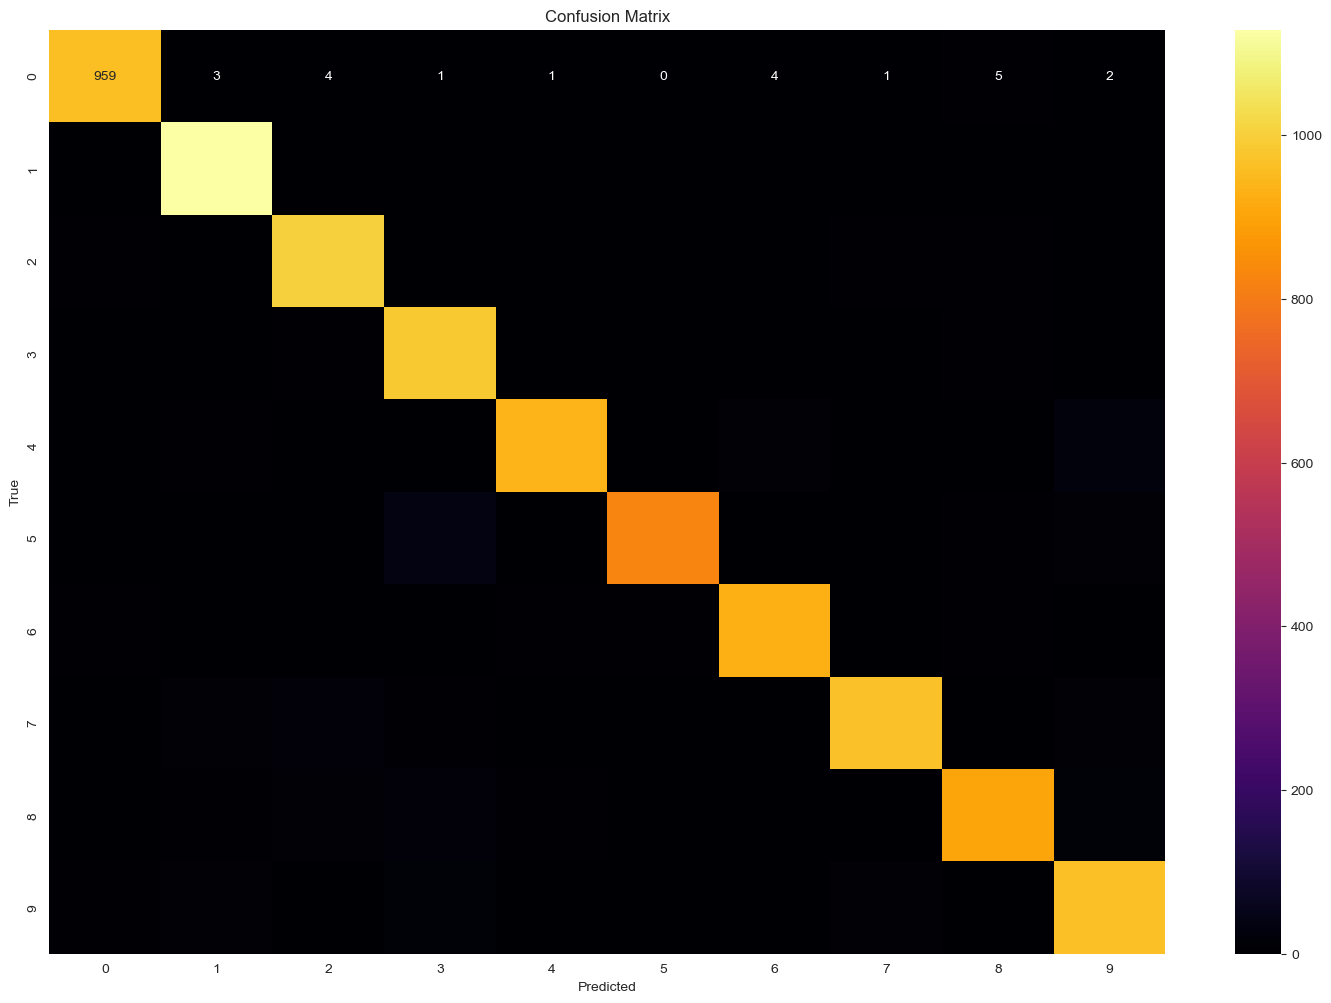

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cnn = load_weights('cnn_weights.pkl')

predictions = cnn.test(x_test=x_test, y_test=y_test)

def predictions_to_labels(predictions):
    return predictions.argmax(axis=1)

y_pred = predictions_to_labels(predictions)
y_true = y_test.argmax(axis=1)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='inferno',
            xticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
            yticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



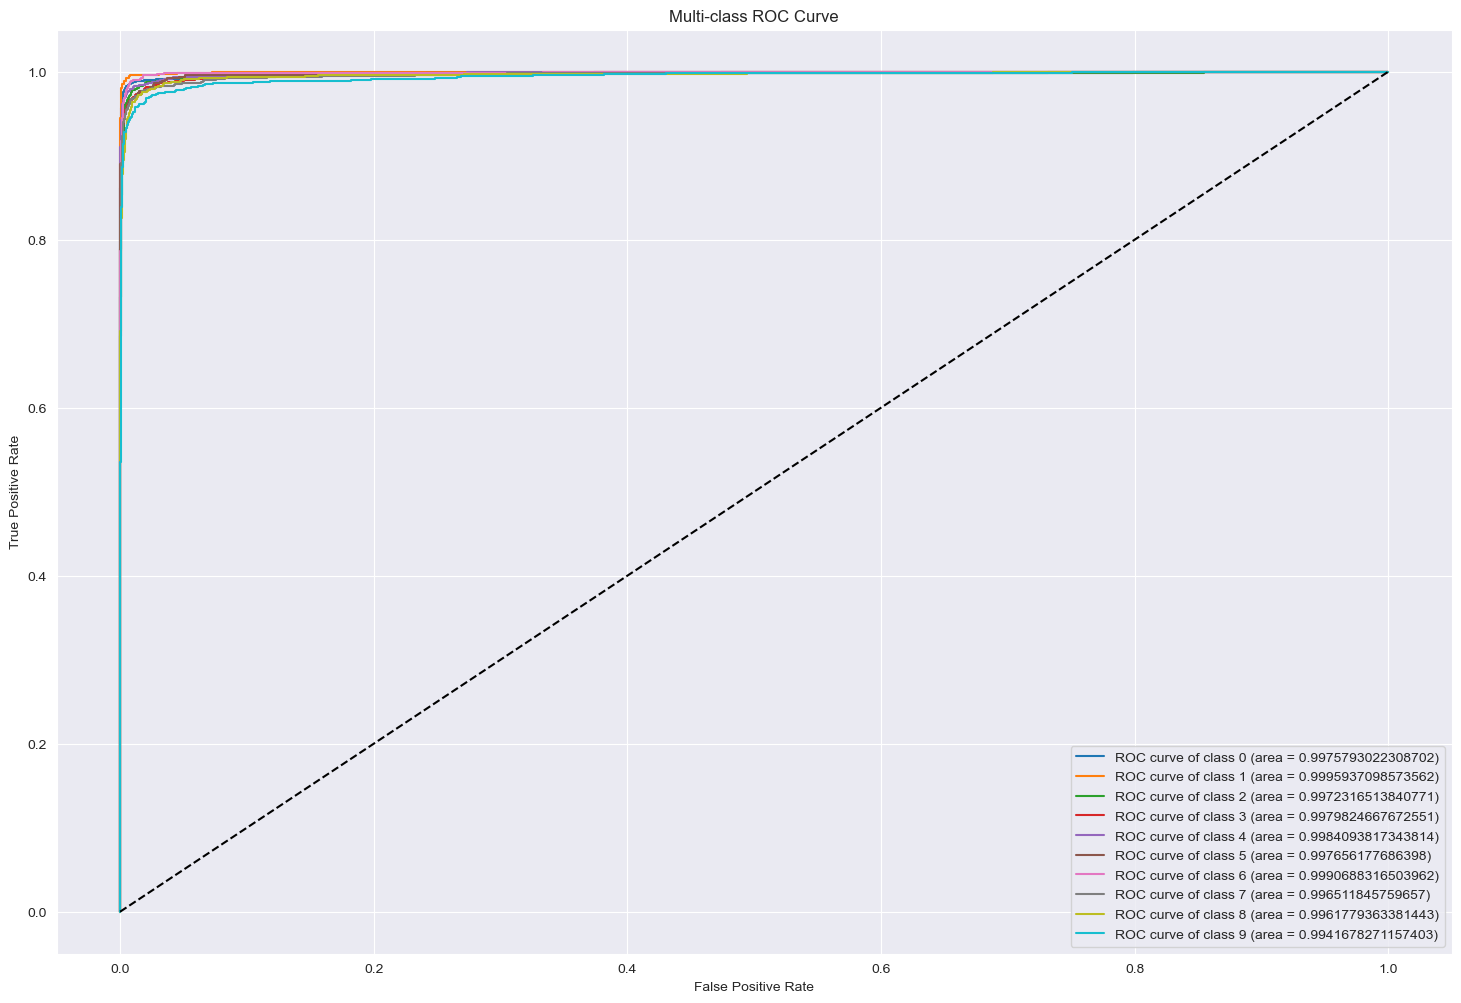

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_true, classes=np.unique(y_true))

tpr = dict()
fpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(18, 12))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()